In [ ]:
pip install entmax

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 62.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from entmax import Entmax15

import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.optim as optim
from datetime import timedelta

#### 1. 데이터 불러오기

---

파생 변수 생성 후 데이터 병합

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/캡스톤/Coffee_Price_Weather.csv")

In [ ]:
df['Coffee_Price_Return'] = df['Coffee_Price'].pct_change()
df['abs_return'] = df['Coffee_Price_Return'].abs()

# 5일, 10일 변동성 (rolling std)
df['volatility_5d'] = df['Coffee_Price_Return'].rolling(window=5).std()
df['volatility_10d'] = df['Coffee_Price_Return'].rolling(window=10).std()

# 5일 평균 수익률
df['momentum_5d'] = df['Coffee_Price'] - df['Coffee_Price'].shift(5)

# Bollinger Band Width (상대 변동성)
rolling_mean = df['Coffee_Price'].rolling(window=20).mean()
rolling_std = df['Coffee_Price'].rolling(window=20).std()
df['bollinger_width'] = (2 * rolling_std) / rolling_mean

# Return Z-score (비정상 변동 탐지)
df['return_zscore'] = (df['Coffee_Price_Return'] - df['Coffee_Price_Return'].rolling(20).mean()) / \
                       (df['Coffee_Price_Return'].rolling(20).std() + 1e-6)

df['momentum_1d'] = df['Coffee_Price'].diff(1)
df['momentum_3d'] = df['Coffee_Price'].diff(3)
df['volatility_ratio'] = df['volatility_5d'] / df['volatility_10d']

In [ ]:
df = df.dropna()

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

<ipython-input-6-a28349389ac4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'])


#### 2. train, test 데이터셋 생성

In [ ]:
n = len(df)
train_size = int(n * 0.8)
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

In [ ]:
from sklearn.preprocessing import StandardScaler

original_train_df = train_df.copy()
original_test_df = test_df.copy()

scaler_seq = StandardScaler()
train_df_scaled = pd.DataFrame(scaler_seq.fit_transform(train_df), columns=train_df.columns, index=train_df.index)
test_df_scaled = pd.DataFrame(scaler_seq.transform(test_df), columns=test_df.columns, index=test_df.index)

train_df_scaled["Coffee_Price_Return"] = original_train_df["Coffee_Price_Return"]
test_df_scaled["Coffee_Price_Return"] = original_test_df["Coffee_Price_Return"]

In [ ]:
class MultiStepTimeSeriesDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, window_size, horizon, step, static_feat_idx):
        self.data = []
        self.labels = []
        self.static_feats = []

        self.seq_feat_idx = [i for i in range(X.shape[1]) if i not in static_feat_idx]

        for i in range(0, len(X) - window_size - horizon + 1, step):
            x_seq = X[i:i+window_size, self.seq_feat_idx]            # (T, D_seq)
            x_static = X[i, static_feat_idx]                         # (D_static,) 시간에 따라 변하지 않음
            y_target = y[i+window_size:i+window_size+horizon]

            self.data.append(x_seq)
            self.static_feats.append(x_static)
            self.labels.append(y_target)

        self.data = np.array(self.data)
        self.static_feats = np.array(self.static_feats)
        self.labels = np.array(self.labels)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x_seq = torch.tensor(self.data[idx], dtype=torch.float32)        # (T, D_seq)
        x_static = torch.tensor(self.static_feats[idx], dtype=torch.float32)  # (D_static,)
        y = torch.tensor(self.labels[idx], dtype=torch.float32)          # (future_target,)
        return x_seq, x_static, y

In [ ]:
target_col = "Coffee_Price_Return"

y_train = train_df_scaled[target_col].values
y_test = test_df_scaled[target_col].values

X_train = train_df_scaled.drop(columns=[target_col]).values
X_test = test_df.drop(columns=[target_col]).values

14일 예측을 위한 데이터셋 생성

In [ ]:
data_window = 100  # 최근 데이터를 입력으로 사용
future_target = 14  # 14개 미래 값 예측
step = 1  # 단위로 샘플링

In [ ]:
static_feat_idx = list(range(X_train.shape[1] - 9, X_train.shape[1]))

train_dataset_14 = MultiStepTimeSeriesDataset(X_train, y_train, data_window, future_target, step, static_feat_idx)
test_dataset_14 = MultiStepTimeSeriesDataset(X_test, y_test, data_window, future_target, step, static_feat_idx)

train_loader_14 = torch.utils.data.DataLoader(train_dataset_14, batch_size=64, shuffle=True)
test_loader_14 = torch.utils.data.DataLoader(test_dataset_14, batch_size=32, shuffle=False)

7일 예측을 위한 데이터셋 생성

In [ ]:
data_window = 100  # 최근 데이터를 입력으로 사용
future_target = 7  # 7개 미래 값 예측
step = 1  # 단위로 샘플링

In [ ]:
static_feat_idx = list(range(X_train.shape[1] - 9, X_train.shape[1]))

train_dataset_7 = MultiStepTimeSeriesDataset(X_train, y_train, data_window, future_target, step, static_feat_idx)
test_dataset_7 = MultiStepTimeSeriesDataset(X_test, y_test, data_window, future_target, step, static_feat_idx)

train_loader_7 = torch.utils.data.DataLoader(train_dataset_7, batch_size=64, shuffle=True)
test_loader_7 = torch.utils.data.DataLoader(test_dataset_7, batch_size=32, shuffle=False)

#### 3. 모델 정의

In [ ]:
class EntmaxAttention(nn.Module):
    def __init__(self, hidden_size, attn_dim=64):
        super().__init__()
        self.score_layer = nn.Sequential(
            nn.Linear(hidden_size, attn_dim),
            nn.Tanh(),
            nn.Linear(attn_dim, 1)
        )
        self.entmax = Entmax15(dim=1)

    def forward(self, lstm_output):
        # lstm_output: (B, T, H)
        scores = self.score_layer(lstm_output).squeeze(-1)  # (B, T)
        weights = self.entmax(scores)  # sparse attention weights
        context = torch.sum(lstm_output * weights.unsqueeze(-1), dim=1)  # (B, H)
        return context, weights

In [ ]:
class AttentionLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, target_size=14, dropout=0.1, static_feat_dim=9):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.target_size = target_size

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0.0,
            batch_first=True
        )

        self.attention = EntmaxAttention(hidden_size)

        self.gate = nn.Sequential(
            nn.Linear(hidden_size * 2, 1),
            nn.Sigmoid()
        )

        self.fc = nn.Sequential(
            nn.Linear(hidden_size + static_feat_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, target_size)
        )

    def forward(self, x_seq, x_static, hidden_states=None):
        batch_size = x_seq.size(0)

        if hidden_states is None:
            h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x_seq.device)
            c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x_seq.device)
            hidden_states = (h0, c0)

        lstm_out, _ = self.lstm(x_seq, hidden_states)  # (B, T, H)

        context, attn_weights_list = self.attention(lstm_out)  # (B, H), list of (B, T)
        last_hidden = lstm_out[:, -1, :]  # (B, H)

        combined = torch.cat([context, last_hidden], dim=1)  # (B, 2H)
        alpha = self.gate(combined)  # (B, 1)
        fused = alpha * context + (1 - alpha) * last_hidden  # (B, H)

        fused_with_static = torch.cat([fused, x_static], dim=1)
        out = self.fc(fused_with_static)  # (B, target_size)

        return out, attn_weights_list

#### 모델 학습

##### 1. 14일간 예측을 위한 모델 학습

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

x_seq, x_static, _ = train_dataset_14[0]

input_size = x_seq.shape[1]
static_feat_dim = x_static.shape[0]
target_size = 14
model = AttentionLSTMModel(input_size=input_size, target_size=target_size, static_feat_dim=9).to(device)
base_criterion = nn.MSELoss()

# 방향성 손실
def directional_loss(y_pred, y_true):
    pred_diff = torch.sign(y_pred[:, 1:] - y_pred[:, :-1])
    true_diff = torch.sign(y_true[:, 1:] - y_true[:, :-1])
    return torch.mean((pred_diff != true_diff).float())

# 분산 차이 손실
def variance_loss(y_pred, y_true):
    return torch.abs(torch.std(y_pred) - torch.std(y_true))

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=10)

In [ ]:
num_epochs = 15
train_losses = []
test_losses = []

alpha = 0.2  # 방향성 손실 가중치
beta = 0.1  # 분산 손실 가중치

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

        # 예측/실제 저장 (통계용)
    all_train_preds = []
    all_train_targets = []

    for batch_idx, (x_seq, x_static, y_batch) in enumerate(train_loader_14):
        x_seq = x_seq.to(device)          # (B, T, D_seq)
        x_static = x_static.to(device)    # (B, D_static)
        y_batch = y_batch.to(device)      # (B, target_size)

        optimizer.zero_grad()
        y_pred, _ = model(x_seq, x_static)

        if y_pred.ndim == 3 and y_pred.shape[-1] == 1:
            y_pred = y_pred.squeeze(-1)

        # 예측값/실제값 수집
        all_train_preds.append(y_pred.detach().cpu())
        all_train_targets.append(y_batch.detach().cpu())

        base_loss = base_criterion(y_pred, y_batch)
        dir_loss = directional_loss(y_pred, y_batch)
        var_loss = variance_loss(y_pred, y_batch)
        loss = base_loss + alpha * dir_loss + beta * var_loss

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
        optimizer.step()

        epoch_loss += loss.item()

    avg_train_loss = epoch_loss / len(train_loader_14)
    train_losses.append(avg_train_loss)

        # === 예측값 로그 ===
    all_train_preds_tensor = torch.cat(all_train_preds, dim=0)
    all_train_targets_tensor = torch.cat(all_train_targets, dim=0)

    y_pred_mean = all_train_preds_tensor.mean().item()
    y_pred_std = all_train_preds_tensor.std().item()
    y_true_mean = all_train_targets_tensor.mean().item()
    y_true_std = all_train_targets_tensor.std().item()

    # Validation
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for x_test_seq, x_test_static, y_test in test_loader_14:
            x_test_seq = x_test_seq.to(device)
            x_test_static = x_test_static.to(device)
            y_test = y_test.to(device)

            y_test_pred, _ = model(x_test_seq, x_test_static)

            if y_test_pred.ndim == 3 and y_test_pred.shape[-1] == 1:
                y_test_pred = y_test_pred.squeeze(-1)

            base_test_loss = base_criterion(y_test_pred, y_test)
            dir_test_loss = directional_loss(y_test_pred, y_test)
            var_test_loss = variance_loss(y_test_pred, y_test)
            total_test_loss = base_test_loss + alpha * dir_test_loss + beta * var_test_loss

            test_loss += total_test_loss.item()

    avg_test_loss = test_loss / len(test_loader_14)
    test_losses.append(avg_test_loss)

    scheduler.step(avg_test_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_test_loss:.4f} | "
          f"y_pred mean: {y_pred_mean:.4f}, std: {y_pred_std:.4f} | "
          f"y_true mean: {y_true_mean:.4f}, std: {y_true_std:.4f}")

Epoch [1/15] | Train Loss: 0.1097 | Val Loss: 0.1098 | y_pred mean: -0.0075, std: 0.0636 | y_true mean: 0.0004, std: 0.0190
Epoch [2/15] | Train Loss: 0.1026 | Val Loss: 0.1090 | y_pred mean: 0.0020, std: 0.0194 | y_true mean: 0.0004, std: 0.0190
Epoch [3/15] | Train Loss: 0.1019 | Val Loss: 0.1102 | y_pred mean: 0.0001, std: 0.0182 | y_true mean: 0.0004, std: 0.0190
Epoch [4/15] | Train Loss: 0.1018 | Val Loss: 0.1086 | y_pred mean: 0.0008, std: 0.0182 | y_true mean: 0.0004, std: 0.0190
Epoch [5/15] | Train Loss: 0.1021 | Val Loss: 0.1117 | y_pred mean: 0.0002, std: 0.0183 | y_true mean: 0.0004, std: 0.0190
Epoch [6/15] | Train Loss: 0.1015 | Val Loss: 0.1140 | y_pred mean: 0.0005, std: 0.0182 | y_true mean: 0.0004, std: 0.0190
Epoch [7/15] | Train Loss: 0.1021 | Val Loss: 0.1142 | y_pred mean: 0.0001, std: 0.0185 | y_true mean: 0.0004, std: 0.0190
Epoch [8/15] | Train Loss: 0.1009 | Val Loss: 0.1120 | y_pred mean: 0.0003, std: 0.0182 | y_true mean: 0.0004, std: 0.0190
Epoch [9/15] | 

##### 2. 7일간 예측을 위한 모델 학습

In [ ]:
x_seq, x_static, _ = train_dataset_7[0]

input_size = x_seq.shape[1]
static_feat_dim = x_static.shape[0]
target_size = 7
model_7 = AttentionLSTMModel(input_size=input_size, target_size=target_size, static_feat_dim=9).to(device)
base_criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model_7.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=10)

In [ ]:
num_epochs = 10
train_losses = []
test_losses = []

alpha = 0.2  # 방향성 손실 가중치
beta = 0.1  # 분산 손실 가중치

for epoch in range(num_epochs):
    model_7.train()
    epoch_loss = 0.0

        # 예측/실제 저장 (통계용)
    all_train_preds = []
    all_train_targets = []

    for batch_idx, (x_seq, x_static, y_batch) in enumerate(train_loader_7):
        x_seq = x_seq.to(device)          # (B, T, D_seq)
        x_static = x_static.to(device)    # (B, D_static)
        y_batch = y_batch.to(device)      # (B, target_size)

        optimizer.zero_grad()
        y_pred, _ = model_7(x_seq, x_static)

        if y_pred.ndim == 3 and y_pred.shape[-1] == 1:
            y_pred = y_pred.squeeze(-1)

        # 예측값/실제값 수집
        all_train_preds.append(y_pred.detach().cpu())
        all_train_targets.append(y_batch.detach().cpu())

        base_loss = base_criterion(y_pred, y_batch)
        dir_loss = directional_loss(y_pred, y_batch)
        var_loss = variance_loss(y_pred, y_batch)
        loss = base_loss + alpha * dir_loss + beta * var_loss

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_7.parameters(), max_norm=5)
        optimizer.step()

        epoch_loss += loss.item()

    avg_train_loss = epoch_loss / len(train_loader_7)
    train_losses.append(avg_train_loss)

        # === 예측값 로그 ===
    all_train_preds_tensor = torch.cat(all_train_preds, dim=0)
    all_train_targets_tensor = torch.cat(all_train_targets, dim=0)

    y_pred_mean = all_train_preds_tensor.mean().item()
    y_pred_std = all_train_preds_tensor.std().item()
    y_true_mean = all_train_targets_tensor.mean().item()
    y_true_std = all_train_targets_tensor.std().item()

    # Validation
    model_7.eval()
    test_loss = 0.0
    with torch.no_grad():
        for x_test_seq, x_test_static, y_test in test_loader_7:
            x_test_seq = x_test_seq.to(device)
            x_test_static = x_test_static.to(device)
            y_test = y_test.to(device)

            y_test_pred, _ = model_7(x_test_seq, x_test_static)

            if y_test_pred.ndim == 3 and y_test_pred.shape[-1] == 1:
                y_test_pred = y_test_pred.squeeze(-1)

            base_test_loss = base_criterion(y_test_pred, y_test)
            dir_test_loss = directional_loss(y_test_pred, y_test)
            var_test_loss = variance_loss(y_test_pred, y_test)
            total_test_loss = base_test_loss + alpha * dir_test_loss + beta * var_test_loss

            test_loss += total_test_loss.item()

    avg_test_loss = test_loss / len(test_loader_7)
    test_losses.append(avg_test_loss)

    scheduler.step(avg_test_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_test_loss:.4f} | "
          f"y_pred mean: {y_pred_mean:.4f}, std: {y_pred_std:.4f} | "
          f"y_true mean: {y_true_mean:.4f}, std: {y_true_std:.4f}")

Epoch [1/10] | Train Loss: 0.1081 | Val Loss: 0.1216 | y_pred mean: 0.0107, std: 0.0629 | y_true mean: 0.0004, std: 0.0190
Epoch [2/10] | Train Loss: 0.1022 | Val Loss: 0.1195 | y_pred mean: 0.0008, std: 0.0183 | y_true mean: 0.0004, std: 0.0190
Epoch [3/10] | Train Loss: 0.1020 | Val Loss: 0.1216 | y_pred mean: 0.0005, std: 0.0181 | y_true mean: 0.0004, std: 0.0190
Epoch [4/10] | Train Loss: 0.1018 | Val Loss: 0.1177 | y_pred mean: 0.0005, std: 0.0184 | y_true mean: 0.0004, std: 0.0190
Epoch [5/10] | Train Loss: 0.1017 | Val Loss: 0.1151 | y_pred mean: 0.0006, std: 0.0177 | y_true mean: 0.0004, std: 0.0190
Epoch [6/10] | Train Loss: 0.1012 | Val Loss: 0.1182 | y_pred mean: 0.0006, std: 0.0191 | y_true mean: 0.0004, std: 0.0190
Epoch [7/10] | Train Loss: 0.1013 | Val Loss: 0.1211 | y_pred mean: 0.0004, std: 0.0177 | y_true mean: 0.0004, std: 0.0190
Epoch [8/10] | Train Loss: 0.1022 | Val Loss: 0.1193 | y_pred mean: 0.0004, std: 0.0184 | y_true mean: 0.0004, std: 0.0190
Epoch [9/10] | T

#### 5. 모델 학습 결과 확인

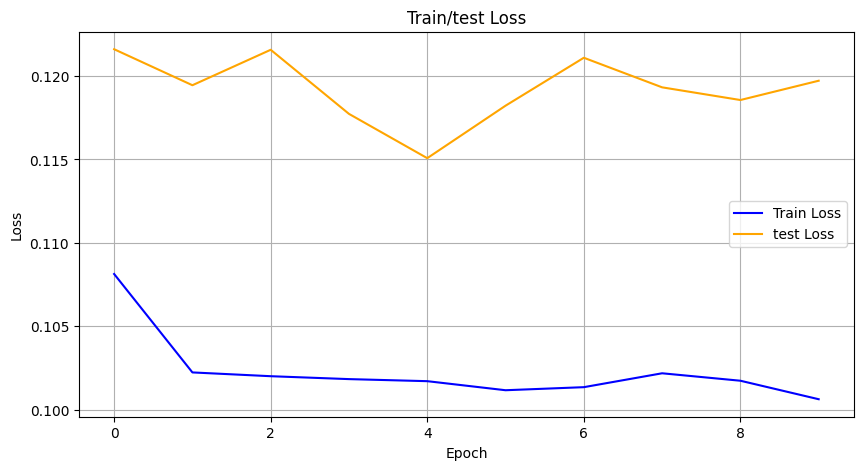

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(test_losses, label='test Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train/test Loss')
plt.legend()
plt.grid(True)
plt.show()

##### 1. 14일간 예측 및 실제값과의 비교

In [ ]:
model.eval()
predictions_14 = []
prediction_dates_list_14 = []

return_col = "Coffee_Price_Return"
price_col = "Coffee_Price"
return_idx = train_df.columns.get_loc(return_col)
future_target = 14

with torch.no_grad():
    for batch_idx, (x_seq, x_static, _) in enumerate(test_loader_14):
        x_seq = x_seq.to(device)         # (B, T, D_seq)
        x_static = x_static.to(device)   # (B, D_static)
        batch_size = x_seq.size(0)

        # 모델 예측
        y_pred_batch, _ = model(x_seq, x_static)  # (B, future_target)
        y_pred_batch = y_pred_batch.cpu().numpy()

        for i in range(batch_size):
            y_pred = y_pred_batch[i].reshape(-1)  # (future_target,)

            # 역정규화를 위한 dummy 입력 생성 (수익률 기준)
            dummy = np.zeros((future_target, len(train_df.columns)))
            dummy[:, return_idx] = y_pred
            return_inv = scaler_seq.inverse_transform(dummy)[:, return_idx]

            # 글로벌 인덱스 계산
            global_idx = (batch_idx * test_loader_14.batch_size + i) * step + data_window
            if global_idx + future_target >= len(test_df):
                break

            # 예측 시점의 시작 가격 확보
            start_timestamp = test_df.index[global_idx]
            start_pos_in_df = df.index.get_loc(start_timestamp)

            # 이전 실제 가격 확보 (return 기반 price 복원 시 기준점)
            try:
                start_price = df[price_col].iloc[start_pos_in_df]
            except IndexError:
                continue  # index out of bounds

            # 미래 날짜 범위 확보
            date_range = df.index[start_pos_in_df + 1 : start_pos_in_df + 1 + future_target]
            if len(date_range) != future_target:
                continue

            # 실제 가격 복원: 누적 수익률 기반
            price_pred = [start_price]
            for r in return_inv:
                price_pred.append(price_pred[-1] * (1 + r))
            price_pred = price_pred[1:]  # 첫 원소는 시작값이므로 제외

            predictions_14.append(pd.Series(price_pred, index=date_range))
            prediction_dates_list_14.extend(date_range)

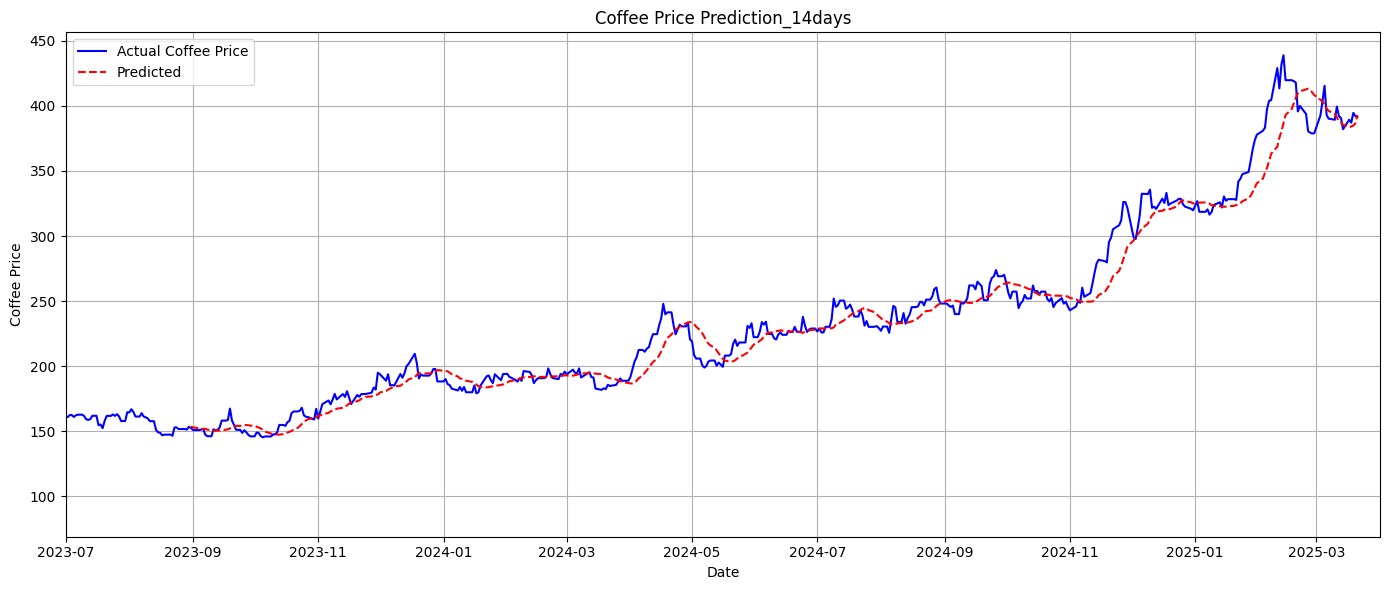

In [ ]:
forecast_all_14 = pd.concat(predictions_14, axis=1).mean(axis=1)  # 날짜 기준 평균 예측

plt.figure(figsize=(14, 6))
plt.plot(df['Coffee_Price'], label='Actual Coffee Price', color='blue')
plt.plot(forecast_all_14.index, forecast_all_14.values, label='Predicted', color='red', linestyle='dashed')
plt.title('Coffee Price Prediction_14days')
plt.xlabel('Date')
plt.ylabel('Coffee Price')
plt.xlim(pd.to_datetime('2023-07-01'), pd.to_datetime('2025-04-01'))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

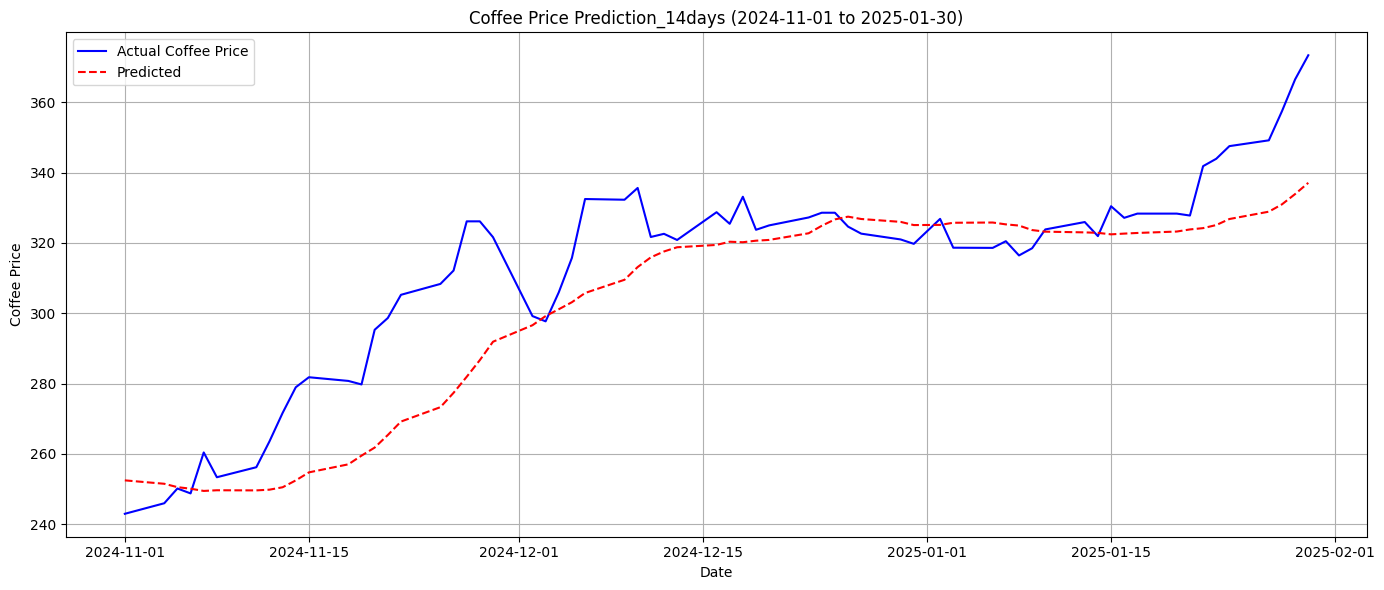

In [ ]:
# 지정 기준 날짜
selected_date = pd.to_datetime("2024-11-01")

start_date = selected_date
end_date = selected_date + pd.Timedelta(days=90)

plt.figure(figsize=(14, 6))
plt.plot(df['Coffee_Price'].loc[start_date:end_date], label='Actual Coffee Price', color='blue')
plt.plot(forecast_all_14.loc[start_date:end_date].index, forecast_all_14.loc[start_date:end_date].values,
         label='Predicted', color='red', linestyle='dashed')
plt.title(f'Coffee Price Prediction_14days ({start_date.date()} to {end_date.date()})')
plt.xlabel('Date')
plt.ylabel('Coffee Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

3달간의 흐름을 확인해보았을 때 전반적인 가격의 흐름을 잘 추적함

In [ ]:
true_series_list_14 = []

for pred_k in predictions_14:
    date_range = pred_k.index
    true_k = df['Coffee_Price'].reindex(date_range)
    true_series_list_14.append(true_k)

##### 2. 7일간 예측 및 실제값과의 비교

In [ ]:
model_7.eval()
predictions_7 = []
prediction_dates_list_7 = []
future_target = 7

return_col = "Coffee_Price_Return"
price_col = "Coffee_Price"
return_idx = train_df.columns.get_loc(return_col)

with torch.no_grad():
    for batch_idx, (x_seq, x_static, _) in enumerate(test_loader_7):
        x_seq = x_seq.to(device)         # (B, T, D_seq)
        x_static = x_static.to(device)   # (B, D_static)
        batch_size = x_seq.size(0)

        # 모델 예측
        y_pred_batch, _ = model_7(x_seq, x_static)  # (B, future_target)
        y_pred_batch = y_pred_batch.cpu().numpy()

        for i in range(batch_size):
            y_pred = y_pred_batch[i].reshape(-1)  # (future_target,)

            # 역정규화를 위한 dummy 입력 생성 (수익률 기준)
            dummy = np.zeros((future_target, len(train_df.columns)))
            dummy[:, return_idx] = y_pred
            return_inv = scaler_seq.inverse_transform(dummy)[:, return_idx]

            # 글로벌 인덱스 계산
            global_idx = (batch_idx * test_loader_7.batch_size + i) * step + data_window
            if global_idx + future_target >= len(test_df):
                break

            # 예측 시점의 시작 가격 확보
            start_timestamp = test_df.index[global_idx]
            start_pos_in_df = df.index.get_loc(start_timestamp)

            # 이전 실제 가격 확보 (return 기반 price 복원 시 기준점)
            try:
                start_price = df[price_col].iloc[start_pos_in_df]
            except IndexError:
                continue  # index out of bounds

            # 미래 날짜 범위 확보
            date_range = df.index[start_pos_in_df + 1 : start_pos_in_df + 1 + future_target]
            if len(date_range) != future_target:
                continue

            # 실제 가격 복원: 누적 수익률 기반
            price_pred = [start_price]
            for r in return_inv:
                price_pred.append(price_pred[-1] * (1 + r))
            price_pred = price_pred[1:]  # 첫 원소는 시작값이므로 제외

            predictions_7.append(pd.Series(price_pred, index=date_range))
            prediction_dates_list_7.extend(date_range)

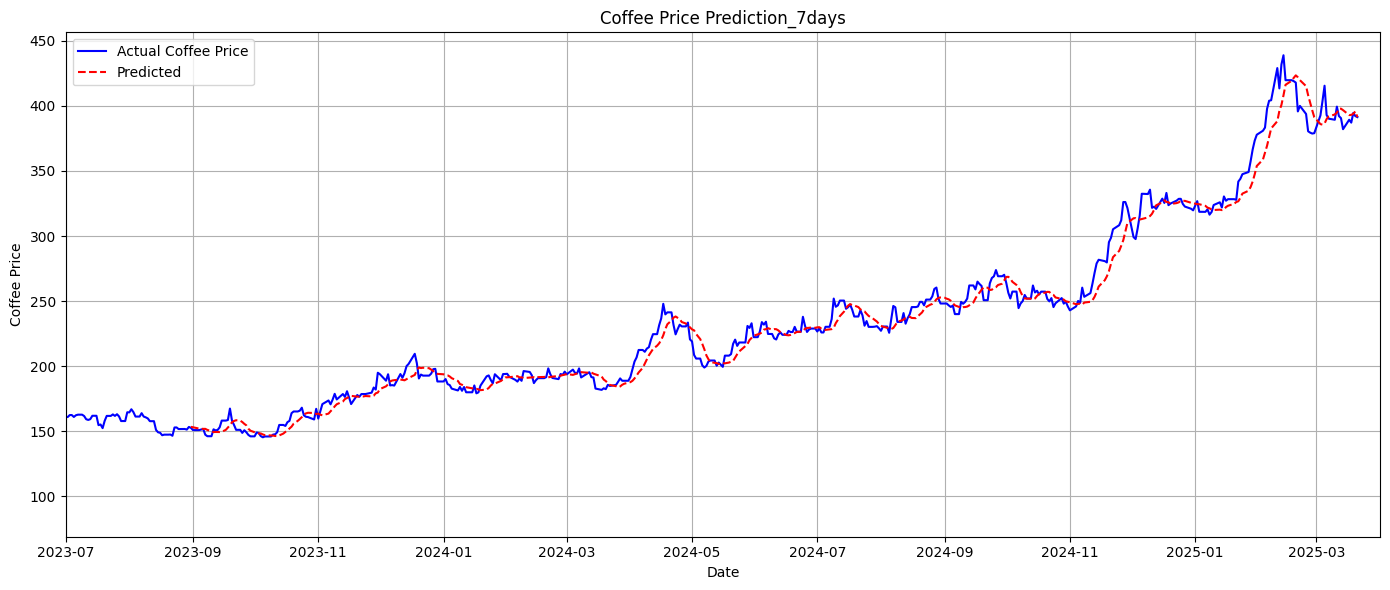

In [ ]:
forecast_all_7 = pd.concat(predictions_7, axis=1).mean(axis=1)  # 날짜 기준 평균 예측

plt.figure(figsize=(14, 6))
plt.plot(df['Coffee_Price'], label='Actual Coffee Price', color='blue')
plt.plot(forecast_all_7.index, forecast_all_7.values, label='Predicted', color='red', linestyle='dashed')
plt.title('Coffee Price Prediction_7days')
plt.xlabel('Date')
plt.ylabel('Coffee Price')
plt.xlim(pd.to_datetime('2023-07-01'), pd.to_datetime('2025-04-01'))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

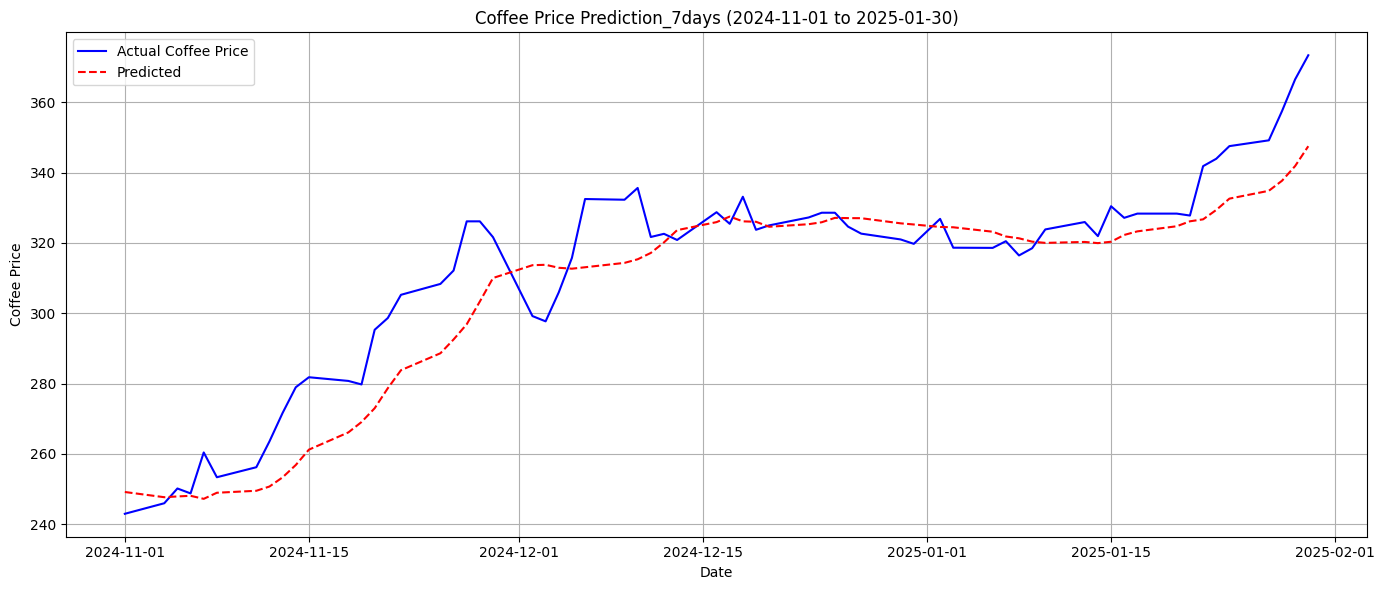

In [ ]:
# 지정 기준 날짜
selected_date = pd.to_datetime("2024-11-01")

start_date = selected_date
end_date = selected_date + pd.Timedelta(days=90)

plt.figure(figsize=(14, 6))
plt.plot(df['Coffee_Price'].loc[start_date:end_date], label='Actual Coffee Price', color='blue')
plt.plot(forecast_all_7.loc[start_date:end_date].index, forecast_all_7.loc[start_date:end_date].values,
         label='Predicted', color='red', linestyle='dashed')
plt.title(f'Coffee Price Prediction_7days ({start_date.date()} to {end_date.date()})')
plt.xlabel('Date')
plt.ylabel('Coffee Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
true_series_list_7 = []

for pred_k in predictions_7:
    date_range = pred_k.index
    true_k = df['Coffee_Price'].reindex(date_range)
    true_series_list_7.append(true_k)

#### 6. 모델 성능 평가

---

+-10원 정도의 오차 있음

14일간 예측 모델의 성능

In [ ]:
actual = df.loc[forecast_all_14.index, 'Coffee_Price']

predicted = forecast_all_14

from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

rmse = np.sqrt(mean_squared_error(actual, predicted))
mae = mean_absolute_error(actual, predicted)

print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")

RMSE: 13.1651
MAE:  9.1161


7일간 예측 모델의 성능

In [ ]:
actual = df.loc[forecast_all_7.index, 'Coffee_Price']

predicted = forecast_all_7

from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

rmse = np.sqrt(mean_squared_error(actual, predicted))
mae = mean_absolute_error(actual, predicted)

print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")

RMSE: 9.3486
MAE:  6.7488


#### 7. 예측 실행하지 않은 부분(sliding window로 인해 sequence 생성 안 된 부분)까지 예측 실행

In [ ]:
all_columns = train_df_scaled.drop(columns=[target_col]).columns.tolist()

static_columns = [all_columns[i] for i in static_feat_idx]
seq_columns = [col for col in all_columns if col not in static_columns]

x_seq_input = test_df.iloc[-data_window:][seq_columns].values
x_seq_input = torch.tensor(x_seq_input, dtype=torch.float32).unsqueeze(0).to(device)

# 2. 마지막 정적 피처 준비
x_static_input = test_df.iloc[-1][static_columns].values  # (D_static,)
x_static_input = torch.tensor(x_static_input, dtype=torch.float32).unsqueeze(0).to(device)  # (1, D_static)

##### 14일간 예측 모델을 통한 예측 실행

In [ ]:
model.eval()
predictions_extended_14 = []

# test_df에서 시퀀스 및 타깃이 추출된 인덱스 범위
last_input_start_idx = len(test_df) - (data_window + 14)
# 시퀀스 마지막 날짜 (기준일)
input_end_date = test_df.index[last_input_start_idx + data_window - 1]

start_date = input_end_date + pd.Timedelta(days=1)
end_date = pd.Timestamp(test_df[-1:].index[0])

target_dates = test_df.loc[start_date:end_date].index

for input_end_date in target_dates:
    input_end_loc = test_df.index.get_loc(input_end_date)
    input_start_loc = input_end_loc - data_window + 1

    # 입력 시퀀스 및 정적 피처 추출
    x_seq_slice = test_df.iloc[input_start_loc:input_end_loc + 1][seq_columns].values
    x_static_vec = test_df.iloc[input_end_loc][static_columns].values

    x_seq_input = torch.tensor(x_seq_slice, dtype=torch.float32).unsqueeze(0).to(device)
    x_static_input = torch.tensor(x_static_vec, dtype=torch.float32).unsqueeze(0).to(device)

    with torch.no_grad():
        y_pred_future, _ = model(x_seq_input, x_static_input)
        y_pred_future = y_pred_future.squeeze(0).cpu().numpy()

    # 역정규화
    dummy = np.zeros((14, len(train_df.columns)))
    dummy[:, return_idx] = y_pred_future
    return_inv = scaler_seq.inverse_transform(dummy)[:, return_idx]

    # 시작가 기준으로 가격 복원
    start_price = test_df[price_col].iloc[input_end_loc]
    price_future = [start_price]
    for r in return_inv:
        price_future.append(price_future[-1] * (1 + r))
    price_future = price_future[1:]

    future_dates = pd.date_range(start=input_end_date + timedelta(days=1), periods=14, freq="D")
    predictions_extended_14.append(pd.Series(price_future, index=future_dates))

In [ ]:
full_predictions_14 = predictions_14 + predictions_extended_14
predictions_full_14 = pd.concat(full_predictions_14, axis=1).mean(axis=1)  # 날짜 기준 평균 예측

result_df_14 = pd.DataFrame({
    "Date": predictions_full_14.index,
    "Predicted_Price": predictions_full_14.values,
    "Actual_Price": df["Coffee_Price"].reindex(predictions_full_14.index).values
})

##### 7일간 예측 모델을 통한 예측 실행

In [ ]:
model_7.eval()
predictions_extended_7 = []

# test_df에서 시퀀스 및 타깃이 추출된 인덱스 범위
last_input_start_idx = len(test_df) - (data_window + 7)
# 시퀀스 마지막 날짜 (기준일)
input_end_date = test_df.index[last_input_start_idx + data_window - 1]

start_date = input_end_date + pd.Timedelta(days=1)
end_date = pd.Timestamp(test_df[-1:].index[0])

target_dates = test_df.loc[start_date:end_date].index

for input_end_date in target_dates:
    input_end_loc = test_df.index.get_loc(input_end_date)
    input_start_loc = input_end_loc - data_window + 1

    # 입력 시퀀스 및 정적 피처 추출
    x_seq_slice = test_df.iloc[input_start_loc:input_end_loc + 1][seq_columns].values
    x_static_vec = test_df.iloc[input_end_loc][static_columns].values

    x_seq_input = torch.tensor(x_seq_slice, dtype=torch.float32).unsqueeze(0).to(device)
    x_static_input = torch.tensor(x_static_vec, dtype=torch.float32).unsqueeze(0).to(device)

    with torch.no_grad():
        y_pred_future, _ = model_7(x_seq_input, x_static_input)
        y_pred_future = y_pred_future.squeeze(0).cpu().numpy()

    # 역정규화
    dummy = np.zeros((7, len(train_df.columns)))
    dummy[:, return_idx] = y_pred_future
    return_inv = scaler_seq.inverse_transform(dummy)[:, return_idx]

    # 시작가 기준으로 가격 복원
    start_price = test_df[price_col].iloc[input_end_loc]
    price_future = [start_price]
    for r in return_inv:
        price_future.append(price_future[-1] * (1 + r))
    price_future = price_future[1:]

    future_dates = pd.date_range(start=input_end_date + timedelta(days=1), periods=7, freq="D")
    predictions_extended_7.append(pd.Series(price_future, index=future_dates))

In [ ]:
full_predictions_7 = predictions_7 + predictions_extended_7
predictions_full_7 = pd.concat(full_predictions_7, axis=1).mean(axis=1)  # 날짜 기준 평균 예측

result_df_7 = pd.DataFrame({
    "Date": predictions_full_7.index,
    "Predicted_Price": predictions_full_7.values,
    "Actual_Price": df["Coffee_Price"].reindex(predictions_full_7.index).values
})

#### 8. 예측 및 데이터프레임 생성

---

현재는 data의 마지막을 test 데이터의 마지막으로 하였기 때문에 위 코드에서 이미 예측 가격을 구하였지만 후에 현재 데이터의 마지막 날짜 다음날의 데이터를 입력하면 밑의 코드들을 이용하면 됨

##### 1. 앞으로의 2주간 가격 흐름 확인 및 데이터프레임 생성

In [ ]:
model.eval()

with torch.no_grad():
    y_pred_future, _ = model(x_seq_input, x_static_input)  # (1, 14)
    y_pred_future = y_pred_future.squeeze(0).cpu().numpy()  # (14,)

dummy = np.zeros((14, len(train_df.columns)))
dummy[:, return_idx] = y_pred_future
return_inv = scaler_seq.inverse_transform(dummy)[:, return_idx]

start_price = test_df[price_col].iloc[-1]

price_future = [start_price]
for r in return_inv:
    price_future.append(price_future[-1] * (1 + r))
price_future = price_future[1:]

last_date = test_df.index[-1]
future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=14, freq='D')

In [ ]:
future_price_series_14 = pd.Series(price_future, index=future_dates)

예측 후에 예측 결과를 저장하고 있는 데이터프레임(result_df_14)에 값이 있는지 확인하고 예측 결과 업데이트

In [ ]:
new_pred_df = future_price_series_14.rename("Predicted_Price").reset_index().rename(columns={"index": "Date"})

merged = pd.merge(result_df_14, new_pred_df, on="Date", how="outer", suffixes=("", "_new"))
merged["Predicted_Price"] = merged[["Predicted_Price", "Predicted_Price_new"]].mean(axis=1)
merged.drop(columns=["Predicted_Price_new"], inplace=True)

result_df_14_updated = merged.sort_values("Date").set_index("Date")

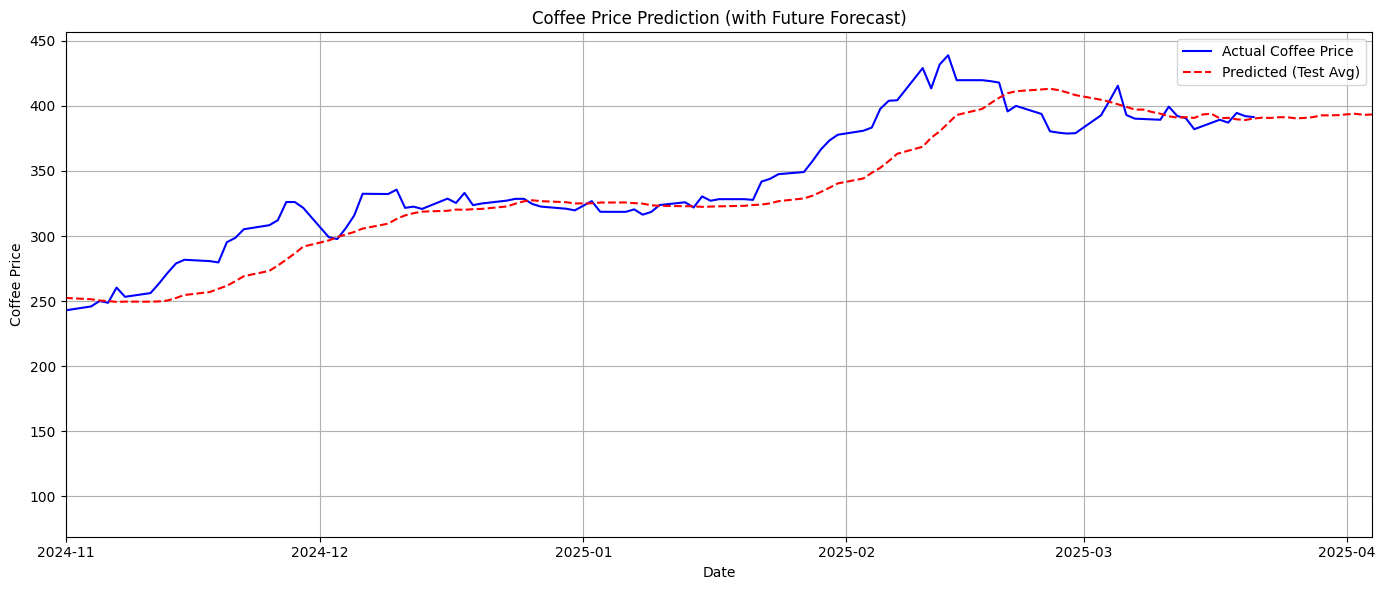

In [ ]:
plt.figure(figsize=(14, 6))

plt.plot(df['Coffee_Price'], label='Actual Coffee Price', color='blue')
plt.plot(result_df_14_updated.index, result_df_14_updated['Predicted_Price'], label='Predicted (Test Avg)', color='red', linestyle='dashed')

plt.title('Coffee Price Prediction (with Future Forecast)')
plt.xlabel('Date')
plt.ylabel('Coffee Price')
plt.xlim(pd.to_datetime('2024-11-01'), future_price_series_14.index[-1])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

##### 2. 앞으로의 1주간 가격 흐름 확인 및 데이터프레임 생성

In [ ]:
model_7.eval()

with torch.no_grad():
    y_pred_future, _ = model_7(x_seq_input, x_static_input)  # (1, 7)
    y_pred_future = y_pred_future.squeeze(0).cpu().numpy()  # (7,)

dummy = np.zeros((7, len(train_df.columns)))
dummy[:, return_idx] = y_pred_future
return_inv = scaler_seq.inverse_transform(dummy)[:, return_idx]

start_price = test_df[price_col].iloc[-1]

price_future = [start_price]
for r in return_inv:
    price_future.append(price_future[-1] * (1 + r))
price_future = price_future[1:]

last_date = test_df.index[-1]
future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=7, freq='D')
future_price_series_7 = pd.Series(price_future, index=future_dates)

예측 후에 예측 결과를 저장하고 있는 데이터프레임(result_df_7)에 값이 있는지 확인하고 예측 결과 업데이트

In [ ]:
new_pred_df = future_price_series_7.rename("Predicted_Price").reset_index().rename(columns={"index": "Date"})

merged = pd.merge(result_df_7, new_pred_df, on="Date", how="outer", suffixes=("", "_new"))
merged["Predicted_Price"] = merged[["Predicted_Price", "Predicted_Price_new"]].mean(axis=1)
merged.drop(columns=["Predicted_Price_new"], inplace=True)

result_df_7_updated = merged.sort_values("Date").set_index("Date")

예측 결과 그래프

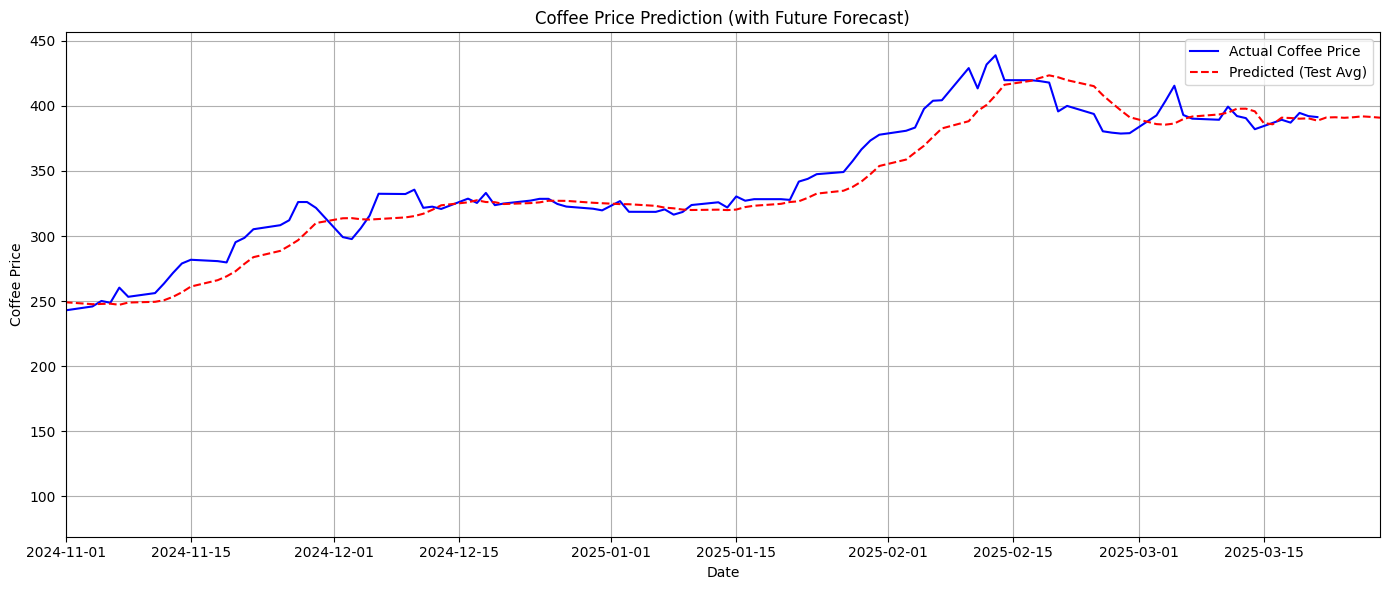

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(df['Coffee_Price'], label='Actual Coffee Price', color='blue')

plt.plot(result_df_7_updated.index, result_df_7_updated['Predicted_Price'], label='Predicted (Test Avg)', color='red', linestyle='dashed')

plt.title('Coffee Price Prediction (with Future Forecast)')
plt.xlabel('Date')
plt.ylabel('Coffee Price')
plt.xlim(pd.to_datetime('2024-11-01'), future_price_series_7.index[-1])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### 8. 모델 결과 활용 방안

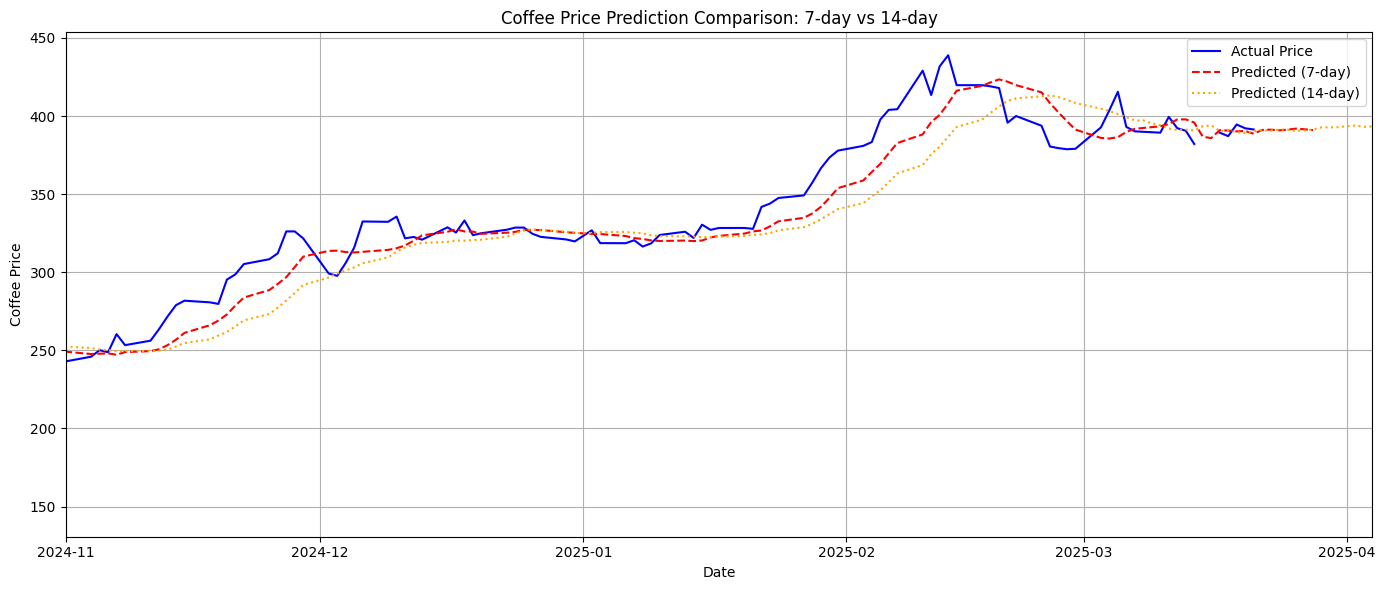

In [ ]:
end_date = pd.to_datetime(result_df_14_updated.index.max())
plt.figure(figsize=(14, 6))

# 실제 커피 가격
plt.plot(result_df_7_updated.index, result_df_7_updated["Actual_Price"], label="Actual Price", color="blue")

# 예측 (7일)
plt.plot(result_df_7_updated.index, result_df_7_updated["Predicted_Price"], label="Predicted (7-day)", color="red", linestyle="dashed")

# 예측 (14일)
plt.plot(result_df_14_updated.index, result_df_14_updated["Predicted_Price"], label="Predicted (14-day)", color="orange", linestyle="dotted")

plt.title("Coffee Price Prediction Comparison: 7-day vs 14-day")
plt.xlabel("Date")
plt.ylabel("Coffee Price")
plt.xlim(pd.to_datetime('2024-11-01'), end_date)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

##### 전략(1) : 커피 가격 구매 타이밍 결정 보조도구

In [ ]:
# 보장: 예측값이 float 형식 Series (각 시점의 D+7, D+14 예측값)
y_pred_7 = result_df_7_updated["Predicted_Price"].astype(float)
y_pred_14 = result_df_14_updated["Predicted_Price"].astype(float)

# 미래 예측 시계열 기반이 없기 때문에, window 평균을 예측 흐름 근사치로 사용
# 예: 과거 7일간의 y_pred_7 평균 = 미래 7일의 흐름으로 가정
trend_window = 4
rolling_window = 14
high_price_filter = y_pred_7.rolling(rolling_window).mean() * 1.05
signal = []

for i in range(rolling_window, len(y_pred_7)):
    short_now = y_pred_7.iloc[i]
    long_now = y_pred_14.iloc[i]

    short_trend_window = y_pred_7.iloc[i - trend_window + 1 : i + 1]
    long_trend_window = y_pred_14.iloc[i - trend_window + 1 : i + 1]

    # 변화율 기준: 현재 예측값 vs. trend 평균
    short_change = (short_now - short_trend_window.mean()) / short_trend_window.mean() * 100
    long_change = (long_now - long_trend_window.mean()) / long_trend_window.mean() * 100

    if short_change > 0.7:
        if long_change > 0.7:
            if short_now < high_price_filter.iloc[i]:
                signal.append("Buy")
            else:
                signal.append("Caution (고점)")
        else:
            signal.append("Caution")
    elif short_change < -0.5 and long_change < -0.5:
        signal.append("Avoid")
    else:
        signal.append("Hold")

# 앞부분 채우기
signal = ["Hold"] * rolling_window + signal

In [ ]:
# 공통 날짜 확보
common_dates = result_df_7_updated.index.intersection(result_df_14_updated.index)

# 공통 날짜 기준 정렬
df_7_common = result_df_7_updated.loc[common_dates]
df_14_common = result_df_14_updated.loc[common_dates]
actual_common = df_14_common["Actual_Price"] if isinstance(df_14_common, pd.DataFrame) else df_14_common

if len(signal) > len(common_dates):
    signal = signal[:len(common_dates)]
elif len(signal) < len(common_dates):
    signal = ["Hold"] * (len(common_dates) - len(signal)) + signal

# 데이터프레임 구성
df_signals = pd.DataFrame({
    "actual": actual_common,
    "7d": y_pred_7,
    "14d": y_pred_14,
    "signal": signal
}, index=common_dates)

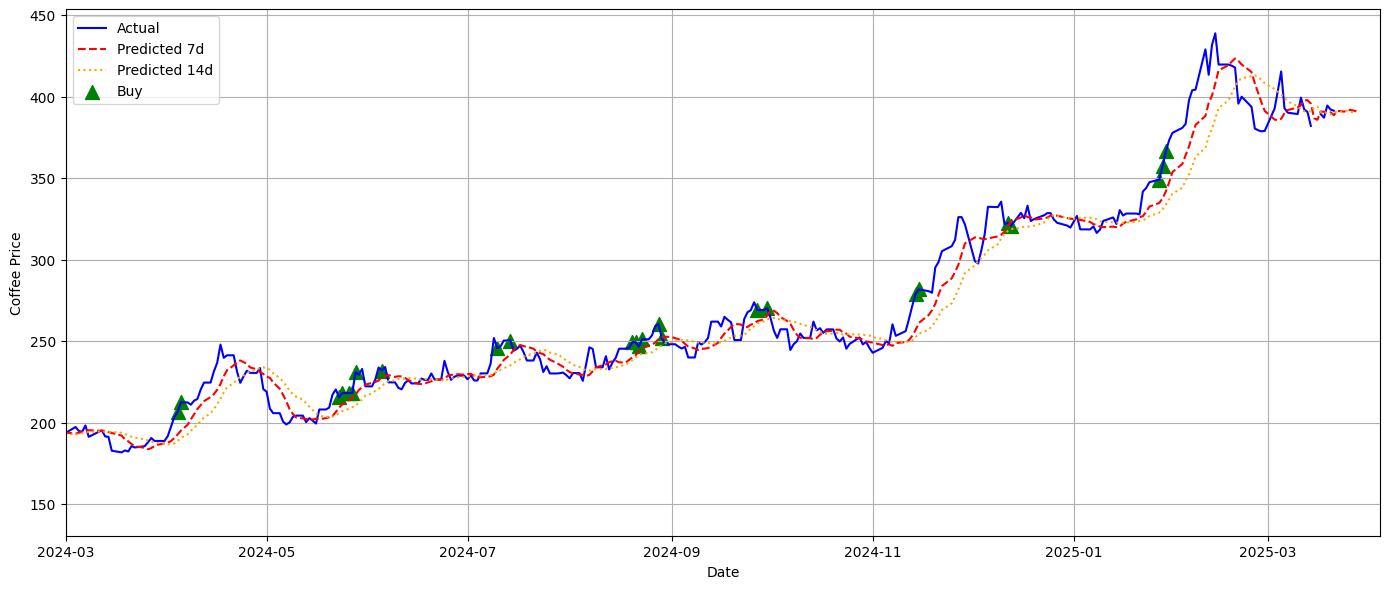

In [ ]:
buy_dates = df_signals[df_signals['signal'] == 'Buy'].index
caution_dates = df_signals[df_signals['signal'] == 'Caution'].index
avoid_dates = df_signals[df_signals['signal'] == 'Avoid'].index

# 7. 시각화
plt.figure(figsize=(14, 6))
plt.plot(df_signals['actual'], label='Actual', color='blue')
plt.plot(df_signals['7d'], label='Predicted 7d', color='red', linestyle='--')
plt.plot(df_signals['14d'], label='Predicted 14d', color='orange', linestyle=':')

plt.scatter(buy_dates, df_signals.loc[buy_dates, 'actual'],
            marker='^', color='green', s=100, label='Buy')
# plt.scatter(caution_dates, df_signals.loc[caution_dates, 'actual'], marker='o', color='yellow', edgecolor='black', label='Caution')
# plt.scatter(avoid_dates, df_signals.loc[avoid_dates, 'actual'], marker='v', color='black', label='Avoid')

plt.xlabel('Date')
plt.ylabel('Coffee Price')
plt.xlim(pd.to_datetime('2024-03-01'), end_date)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

##### 전략(2) : 예측 분기 갑지 및 신뢰도 지표 이용한 구매 결정 보조도구 고도화

###### 2-1 : 예측 분기 감지

In [ ]:
# 스프레드 계산
spread = y_pred_7.loc[common_dates] - y_pred_14.loc[common_dates]

# 동적 임계값 계산: 각 날짜별로 해당 시점 기준 과거 30일 평균 가격 × 2%
thresholds = []
for date in common_dates:
    past_30 = df["Coffee_Price"].loc[:date].dropna().tail(30)
    if len(past_30) < 10:  # 데이터 부족할 경우 threshold = NaN
        thresholds.append(np.nan)
    else:
        thresholds.append(0.02 * past_30.mean())

threshold_series = pd.Series(thresholds, index=common_dates)

In [ ]:
df_signals = df_signals.loc[common_dates].copy()
df_signals["spread"] = spread.values
df_signals["spread_threshold"] = threshold_series.values

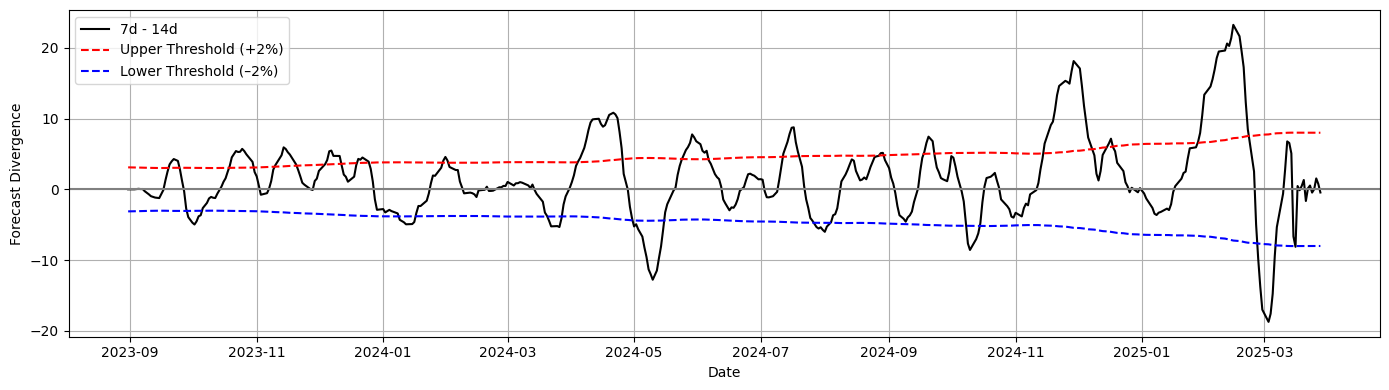

In [ ]:
plt.figure(figsize=(14, 4))
plt.plot(common_dates, spread, label='7d - 14d', color='black')
plt.plot(common_dates, threshold_series, linestyle='--', color='red', label='Upper Threshold (+2%)')
plt.plot(common_dates, -threshold_series, linestyle='--', color='blue', label='Lower Threshold (–2%)')
plt.axhline(0, color='gray', linestyle='-')

plt.xlabel("Date")
plt.ylabel("Forecast Divergence")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

###### 2-2 : 예측 신뢰도 지표


In [ ]:
confidence = 1 - np.abs(y_pred_7.loc[common_dates] - y_pred_14.loc[common_dates]) / (y_pred_14.loc[common_dates] + 1e-6)
df_signals = df_signals.loc[common_dates]
df_signals["confidence"] = confidence.values

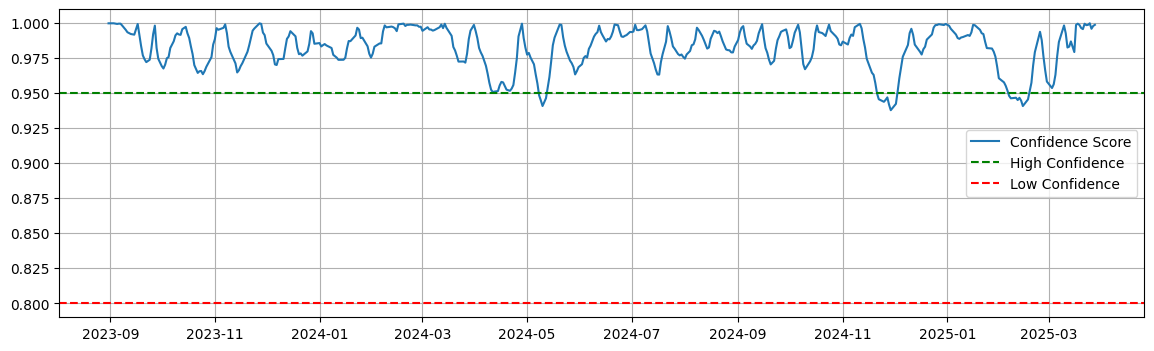

In [ ]:
plt.figure(figsize=(14, 4))
plt.plot(df_signals.index, df_signals['confidence'], label='Confidence Score')
plt.axhline(y=0.95, color='green', linestyle='--', label='High Confidence')
plt.axhline(y=0.80, color='red', linestyle='--', label='Low Confidence')
plt.legend()
plt.grid(True)
plt.show()

###### 2-3 : 예측 분기 갑지 및 신뢰도 지표 이용하여 signal 변경

In [ ]:
conf_cutoff = 0.95
df_signals["confidence"] = confidence.values

def adjust_signal(row):
    if row["confidence"] < conf_cutoff and row["signal"] in ["Buy"]:
        return "Caution (불확실)"
    if pd.notna(row["spread_threshold"]) and abs(row["spread"]) > row["spread_threshold"] and row["signal"] in ["Buy"]:
        return "Caution (분기)"
    return row["signal"]

df_signals["signal_adjusted"] = df_signals.apply(adjust_signal, axis=1)

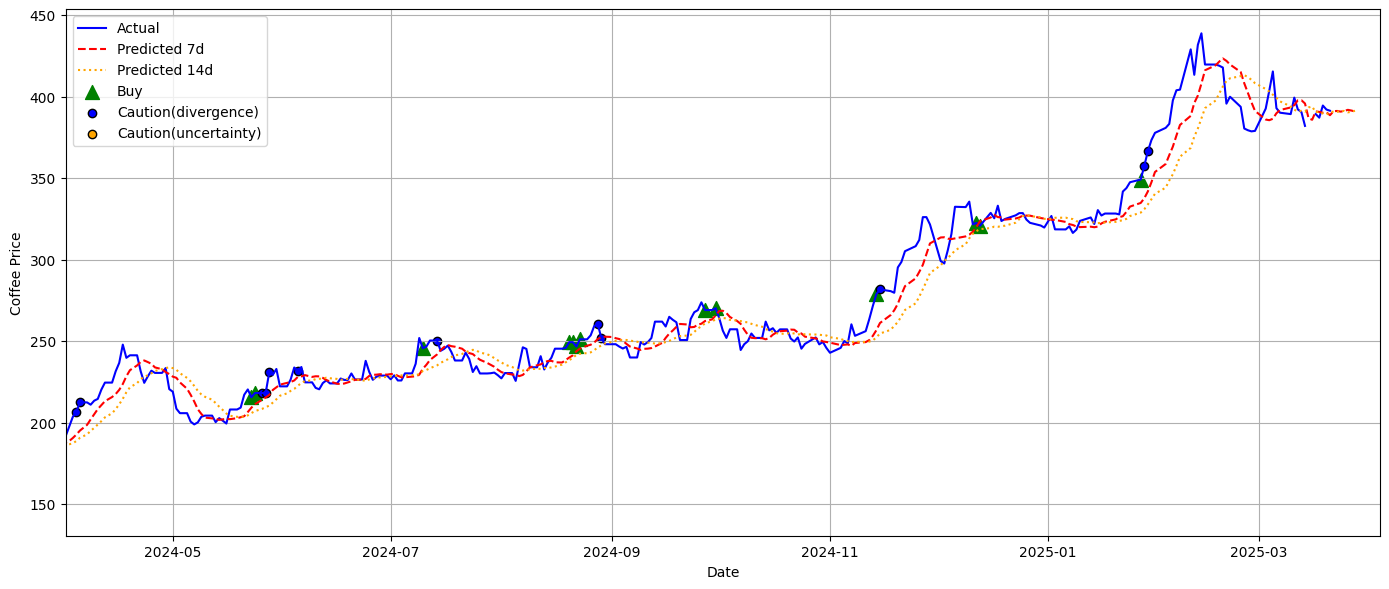

In [ ]:
buy_dates = df_signals[df_signals['signal_adjusted'] == 'Buy'].index
Caution_dates = df_signals[df_signals['signal_adjusted'] == 'Caution'].index
Caution_spread_dates = df_signals[df_signals['signal_adjusted'] == 'Caution (분기)'].index
Caution_confidence_dates = df_signals[df_signals['signal_adjusted'] == 'Caution (불확실)'].index
avoid_dates = df_signals[df_signals['signal_adjusted'] == 'Avoid'].index

# 7. 시각화
plt.figure(figsize=(14, 6))
plt.plot(df_signals['actual'], label='Actual', color='blue')
plt.plot(df_signals['7d'], label='Predicted 7d', color='red', linestyle='--')
plt.plot(df_signals['14d'], label='Predicted 14d', color='orange', linestyle=':')

plt.scatter(buy_dates, df_signals.loc[buy_dates, 'actual'], marker='^', s=100, color='green', label='Buy')
# plt.scatter(Caution_dates, df_signals.loc[Caution_dates, 'actual'], marker='o', color='yellow', edgecolor='black', label='Caution')
plt.scatter(Caution_spread_dates, df_signals.loc[Caution_spread_dates, 'actual'], marker='o', color='blue', edgecolor='black', label='Caution(divergence)')
plt.scatter(Caution_confidence_dates, df_signals.loc[Caution_confidence_dates, 'actual'], marker='o', color='orange', edgecolor='black', label='Caution(uncertainty)')
# plt.scatter(avoid_dates, df_signals.loc[avoid_dates, 'actual'], marker='v', color='black', label='Avoid')

plt.xlabel('Date')
plt.ylabel('Coffee Price')
plt.xlim(pd.to_datetime('2024-04-01'), end_date)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()